Kept 5400 position samples within the track.
Generated 678 spikes.

Calculating rate map (will trigger JIT compilation if needed)...
Target sigma=3.54 cm (0.71 bins). Using D_sim=1.0 bins^2/unit_time.
Required T_sim=0.25 unit_time. Calculated dt=0.0500, N_steps=6

Plotting results...


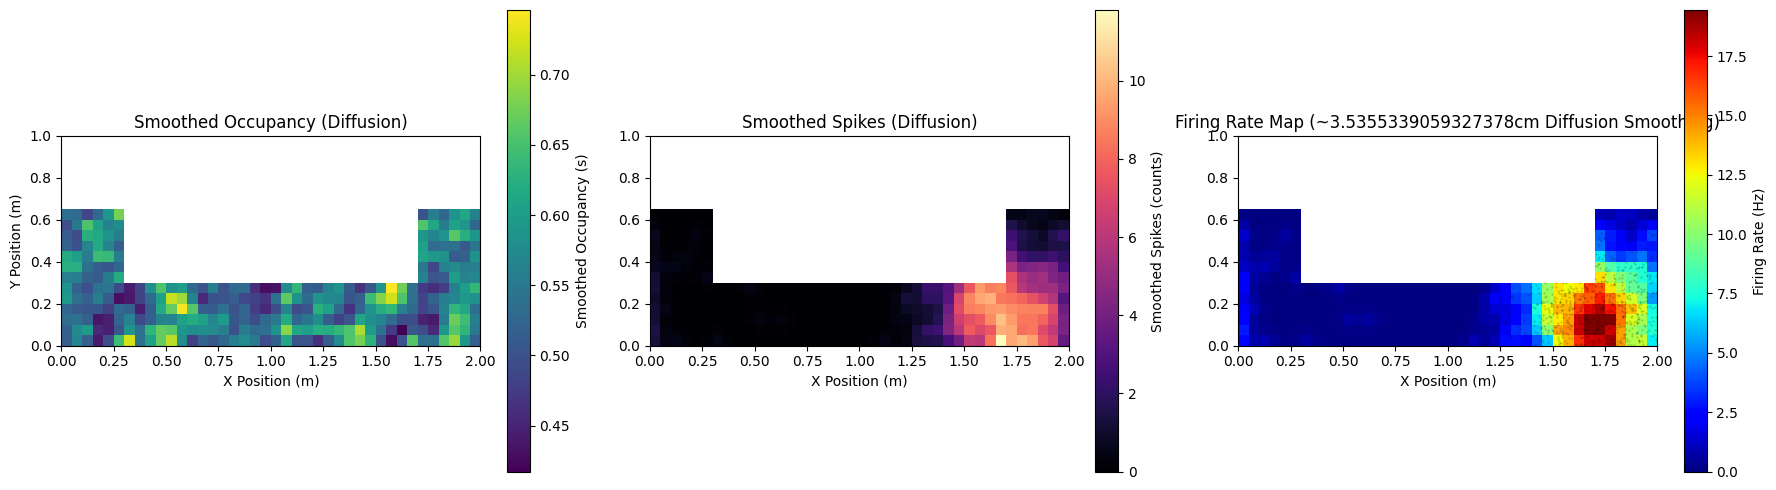

In [7]:
import time
import math
from functools import partial
from typing import Tuple, Union  # Added Union for potential future use

import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import numpy as np


# --- Diffusion Simulation Helper Functions (Assume dx=dy=1 bin unit) ---


@partial(jit, static_argnames=["grid_shape"])
def map_points_to_grid(
    points_xy: jnp.ndarray,
    x_edges: jnp.ndarray,
    y_edges: jnp.ndarray,
    grid_shape: Tuple[int, int],
) -> jnp.ndarray:
    """Maps continuous (x, y) points to grid bins and returns counts per bin.

    Args:
        points_xy: An (N, 2) array of (x, y) coordinates.
        x_edges: A 1D array of bin edges for the x-axis.
        y_edges: A 1D array of bin edges for the y-axis.
        grid_shape: A tuple (n_bins_y, n_bins_x) representing the grid dimensions.

    Returns:
        A (n_bins_y, n_bins_x) array containing the count of points in each bin.
    """
    n_bins_y, n_bins_x = grid_shape
    # Use edges excluding the outermost ones for digitize
    x_indices = jnp.digitize(points_xy[:, 0], x_edges[1:-1])
    y_indices = jnp.digitize(points_xy[:, 1], y_edges[1:-1])
    # Clip indices to ensure they are within the valid range [0, n_bins-1]
    x_indices = jnp.clip(x_indices, 0, n_bins_x - 1)
    y_indices = jnp.clip(y_indices, 0, n_bins_y - 1)

    initial_counts = jnp.zeros(grid_shape, dtype=jnp.float32)
    # Use index update method compatible across JAX versions
    try:
        # Recommended for JAX versions < ~0.4.24
        initial_counts = jax.ops.index_add(
            initial_counts, jax.ops.index[y_indices, x_indices], 1.0
        )
    except AttributeError:
        # Recommended for JAX versions >= ~0.4.24
        initial_counts = initial_counts.at[y_indices, x_indices].add(1.0)
    return initial_counts


@jit
def calculate_laplacian_neumann(
    grid: jnp.ndarray, interior_mask: jnp.ndarray
) -> jnp.ndarray:
    """Calculates the discrete Laplacian assuming dx=dy=1 grid spacing,
       applying reflecting (Neumann) boundary conditions based on the interior_mask.

    Args:
        grid: The 2D grid array (n_bins_y, n_bins_x) representing density/values.
        interior_mask: A boolean array of the same shape as grid, True for valid bins.

    Returns:
        The calculated Laplacian values for each bin within the interior mask.
    """
    # Get neighboring values using jnp.roll
    gw = jnp.roll(grid, shift=1, axis=1)  # West neighbor (left)
    ge = jnp.roll(grid, shift=-1, axis=1)  # East neighbor (right)
    gs = jnp.roll(grid, shift=1, axis=0)  # South neighbor (down)
    gn = jnp.roll(grid, shift=-1, axis=0)  # North neighbor (up)

    # Get masks indicating if neighbors are inside the track
    mask_w = jnp.roll(interior_mask, shift=1, axis=1)
    mask_e = jnp.roll(interior_mask, shift=-1, axis=1)
    mask_s = jnp.roll(interior_mask, shift=1, axis=0)
    mask_n = jnp.roll(interior_mask, shift=-1, axis=0)

    # Apply reflecting boundary: If a neighbor is outside the track,
    # use the current cell's value instead (zero flux).
    gw = jnp.where(mask_w, gw, grid)
    ge = jnp.where(mask_e, ge, grid)
    gs = jnp.where(mask_s, gs, grid)
    gn = jnp.where(mask_n, gn, grid)

    # Calculate Laplacian components (assuming dx=1, dy=1)
    lap_x = gw + ge - 2 * grid
    lap_y = gs + gn - 2 * grid

    # Return Laplacian, masked to apply only within the track interior
    return (lap_x + lap_y) * interior_mask


# D_sim and dt are static arguments, known at compile time
@partial(jit, static_argnames=["D_sim", "dt"])
def diffusion_step(
    grid: jnp.ndarray, D_sim: float, dt: float, interior_mask: jnp.ndarray
) -> jnp.ndarray:
    """Performs one explicit Euler time step for the 2D heat/diffusion equation.
       Assumes dx=dy=1 grid spacing.

    Args:
        grid: Current density grid (n_bins_y, n_bins_x).
        D_sim: Simulation diffusion coefficient (in bins^2 / simulation_time_unit).
        dt: Simulation time step (in simulation_time_unit).
        interior_mask: Boolean mask for track interior.

    Returns:
        The updated density grid after one time step.
    """
    laplacian = calculate_laplacian_neumann(grid, interior_mask)
    # Explicit Euler update rule: u(t+dt) = u(t) + dt * D * laplacian(u(t))
    new_grid = grid + dt * D_sim * laplacian
    # Ensure density remains zero outside the track
    return new_grid * interior_mask


# n_steps, D_sim, and dt are static arguments
@partial(jit, static_argnames=["n_steps", "D_sim", "dt"])
def run_diffusion(
    initial_grid: jnp.ndarray,
    n_steps: int,
    D_sim: float,
    dt: float,
    interior_mask: jnp.ndarray,
) -> jnp.ndarray:
    """Runs the diffusion simulation for a fixed number of steps using lax.scan.
       Assumes dx=dy=1 grid spacing.

    Args:
        initial_grid: The starting density grid (n_bins_y, n_bins_x).
        n_steps: The number of simulation steps (compile-time constant).
        D_sim: Simulation diffusion coefficient (compile-time constant).
        dt: Simulation time step (compile-time constant).
        interior_mask: Boolean mask for track interior.

    Returns:
        The final density grid after n_steps of diffusion.
    """

    # Define the function for a single step compatible with lax.scan
    # It takes the current state (grid) and a dummy input (_),
    # returning the next state and a dummy output (None).
    def scan_step(current_grid, _):
        next_grid = diffusion_step(current_grid, D_sim, dt, interior_mask)
        return next_grid, None

    # Use lax.scan for efficient iteration within JIT context
    final_grid, _ = jax.lax.scan(scan_step, initial_grid, xs=None, length=n_steps)
    return final_grid


# --- Main Internal JIT-Compiled Calculation Function ---


# Static arguments are known at compile time and affect the compiled code.
@partial(
    jit,
    static_argnames=["grid_shape", "fs", "D_sim", "dt", "n_steps"],
)
def calculate_rate_map_diffusion_jax_internal(
    # Dynamic Array Arguments (change between calls)
    spike_pos_xy: jnp.ndarray,
    occupancy_pos_xy: jnp.ndarray,
    x_edges: jnp.ndarray,
    y_edges: jnp.ndarray,
    interior_mask: jnp.ndarray,
    # Static Arguments (fixed for a given compilation)
    fs: float,
    grid_shape: Tuple[int, int],
    D_sim: float,
    dt: float,
    n_steps: int,
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """Internal JIT-compiled function to calculate diffusion-smoothed rate map.

    Assumes dx=dy=1 grid spacing for diffusion simulation. Normalization and
    rate calculations are performed.

    Args:
        spike_pos_xy: (N, 2) array of spike coordinates.
        occupancy_pos_xy: (M, 2) array of all position sample coordinates.
        x_edges: 1D array of x bin edges (needed for mapping).
        y_edges: 1D array of y bin edges (needed for mapping).
        interior_mask: Boolean grid mask (True=inside track).
        fs: Position sampling rate (Hz, static).
        grid_shape: Tuple (n_bins_y, n_bins_x) (static).
        D_sim: Simulation diffusion coefficient (bins^2/unit_time, static).
        dt: Simulation time step (unit_time, static).
        n_steps: Number of simulation steps (static).

    Returns:
        A tuple containing:
            - firing_rate_map (Hz)
            - diffused_spike_counts_scaled (total spikes smoothed)
            - diffused_occupancy_time (seconds smoothed)
    """
    n_bins_y, n_bins_x = grid_shape

    # --- 1. Map data to initial grid counts ---
    initial_spike_counts = map_points_to_grid(
        spike_pos_xy, x_edges, y_edges, grid_shape
    )
    initial_occupancy_counts = map_points_to_grid(
        occupancy_pos_xy, x_edges, y_edges, grid_shape
    )
    # Ensure initial counts are zero outside the valid track area
    initial_spike_counts *= interior_mask
    initial_occupancy_counts *= interior_mask

    # --- 2. Run Diffusion Simulation ---
    diffused_spikes = run_diffusion(
        initial_spike_counts, n_steps, D_sim, dt, interior_mask
    )
    diffused_occupancy = run_diffusion(
        initial_occupancy_counts, n_steps, D_sim, dt, interior_mask
    )

    # --- 3. Normalize Diffused Maps & Compute Rate ---
    # Calculate initial total counts/time within the track
    total_occupancy_counts_in = jnp.sum(initial_occupancy_counts)
    total_spikes_in = jnp.sum(initial_spike_counts)
    total_time_seconds = total_occupancy_counts_in / fs

    # Calculate sums after diffusion (diffusion should approximately conserve sum)
    sum_diffused_occ = jnp.sum(diffused_occupancy)
    sum_diffused_spk = jnp.sum(diffused_spikes)

    # Add small epsilon for numerical stability if sums are near zero after diffusion
    safe_sum_diffused_occ = sum_diffused_occ + 1e-12
    safe_sum_diffused_spk = sum_diffused_spk + 1e-12

    # Normalize occupancy map to represent time in seconds per bin
    diffused_occupancy_time = (
        diffused_occupancy / safe_sum_diffused_occ
    ) * total_time_seconds

    # Normalize spike map to represent total spike counts per bin
    # Handle case where there were no initial spikes
    diffused_spike_counts_scaled = jnp.where(
        total_spikes_in > 0,
        (diffused_spikes / safe_sum_diffused_spk) * total_spikes_in,
        jnp.zeros_like(diffused_spikes),  # Result is 0 if no spikes
    )

    # --- Calculate Firing Rate (Hz) ---
    epsilon = 1e-9  # Prevent division by zero for rate calculation
    # Ensure occupancy time isn't negative due to numerical errors
    safe_occupancy_time = jnp.maximum(diffused_occupancy_time, 0.0)
    firing_rate_map = diffused_spike_counts_scaled / (safe_occupancy_time + epsilon)
    # Ensure rate is zero outside the track
    firing_rate_map *= interior_mask

    return firing_rate_map, diffused_spike_counts_scaled, diffused_occupancy_time


# --- User-Facing Wrapper Function ---


def calculate_rate_map_diffusion_jax(
    # Data Inputs
    spike_pos_xy: Union[np.ndarray, jnp.ndarray],
    occupancy_pos_xy: Union[np.ndarray, jnp.ndarray],
    x_edges: Union[np.ndarray, jnp.ndarray],
    y_edges: Union[np.ndarray, jnp.ndarray],
    interior_mask: Union[np.ndarray, jnp.ndarray],
    fs: float,
    grid_shape: Tuple[int, int],
    grid_res: float,  # Grid resolution in meters/bin
    # Smoothing Parameter
    sigma_cm: float = 5.0,  # Target Gaussian sigma in cm
    # Simulation Parameter
    dt_stability_factor: float = 0.2,  # Safety factor for time step (<~0.25)
    # Options
    verbose: bool = True,
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    """Calculates a diffusion-smoothed firing rate map using JAX.

    This function parameterizes the smoothing level via an equivalent
    Gaussian standard deviation (`sigma_cm`) specified in physical units (cm).
    It runs a 2D diffusion simulation on a grid (assuming dx=dy=1 bin units
    internally for stability) with reflecting boundaries defined by
    `interior_mask`.

    Args:
        spike_pos_xy: (N, 2) array of spike (x, y) coordinates.
        occupancy_pos_xy: (M, 2) array of all position sample (x, y) coordinates.
        x_edges: 1D array of x bin edges.
        y_edges: 1D array of y bin edges.
        interior_mask: Boolean grid mask (True=inside track), shape (n_bins_y, n_bins_x).
        fs: Position sampling rate (Hz).
        grid_shape: Tuple (n_bins_y, n_bins_x).
        grid_res: Grid resolution in meters/bin (e.g., 0.05).
        sigma_cm: Desired smoothing level expressed as the standard deviation
                  of an equivalent Gaussian kernel in centimeters. Defaults to 5.0.
        dt_stability_factor: Safety factor applied to the calculated maximum stable
                             time step for the simulation (should be < ~0.25). Defaults to 0.2.
        verbose: If True, print calculated simulation parameters and timing. Defaults to True.

    Returns:
        A tuple containing JAX arrays:
            - firing_rate_map (Hz)
            - diffused_spike_counts_scaled (total spikes smoothed)
            - diffused_occupancy_time (seconds smoothed)
    """
    # --- Input Validation and Conversion ---
    if sigma_cm <= 0:
        raise ValueError("sigma_cm must be positive")
    if grid_res <= 0:
        raise ValueError("grid_res must be positive")
    if dt_stability_factor <= 0 or dt_stability_factor >= 0.25:
        print(
            f"Warning: dt_stability_factor ({dt_stability_factor}) is outside the typical safe range (0, 0.25)."
        )

    # Ensure inputs are JAX arrays
    spike_pos_xy_jax = jnp.asarray(spike_pos_xy)
    occupancy_pos_xy_jax = jnp.asarray(occupancy_pos_xy)
    x_edges_jax = jnp.asarray(x_edges)
    y_edges_jax = jnp.asarray(y_edges)
    interior_mask_jax = jnp.asarray(interior_mask, dtype=bool)

    # --- Calculate Diffusion Parameters based on sigma_cm ---
    CM_PER_METER = 100.0
    res_cm = grid_res * CM_PER_METER  # Convert m/bin to cm/bin
    sigma_bins = sigma_cm / res_cm  # Target sigma in bin units (equivalent to 'h')

    # Fix simulation diffusion coefficient in bin units for simplicity
    # D_sim relates bins^2 to abstract simulation time units
    D_sim = 1.0  # bins^2 / unit_time

    # Calculate required total simulation time T_sim using sigma_bins^2 = 2 * D_sim * T_sim
    T_sim = (sigma_bins**2) / (2.0 * D_sim)

    # Calculate stable dt and number of steps based on D_sim and dx=dy=1 assumption
    # max_stable_dt = 1 / (2 * D_sim * (1/dx^2 + 1/dy^2)) with dx=dy=1
    max_stable_dt = 1.0 / (4.0 * D_sim)
    dt = float(dt_stability_factor * max_stable_dt)

    if dt <= 0:
        raise ValueError(f"Calculated dt is not positive ({dt}). Check parameters.")
    # Calculate number of steps needed to reach T_sim
    n_steps = max(1, math.ceil(T_sim / dt))

    if verbose:
        print(
            f"Target sigma={sigma_cm:.2f} cm ({sigma_bins:.2f} bins). Using D_sim={D_sim:.1f} bins^2/unit_time."
        )
        print(
            f"Required T_sim={T_sim:.2f} unit_time. Calculated dt={dt:.4f}, N_steps={n_steps}"
        )

    # --- Prepare Static Arguments for JIT ---
    fs_static = float(fs)

    static_args_for_internal = {
        "fs": fs_static,
        "grid_shape": grid_shape,
        "D_sim": D_sim,  # Use the fixed D_sim=1.0
        "dt": dt,
        "n_steps": n_steps,
    }

    # Partially apply static args using functools.partial
    # This allows JAX to compile a specialized version for these static values
    internal_func_partial = partial(
        calculate_rate_map_diffusion_jax_internal, **static_args_for_internal
    )

    # JIT compile the partially applied function
    compiled_internal_func = jit(internal_func_partial)

    # --- Execute the Compiled Function ---
    # Pass only the non-static JAX array arguments
    result = compiled_internal_func(
        spike_pos_xy_jax,
        occupancy_pos_xy_jax,
        x_edges_jax,
        y_edges_jax,
        interior_mask_jax,
    )

    return result


# --- Example Usage ---

if __name__ == "__main__":  # Ensures example runs only when script is executed directly
    # Use NumPy for data generation, then pass to the JAX function
    np.random.seed(42)

    # --- 1. Define Grid and Track Mask ---
    GRID_RESOLUTION_M_PER_BIN = 0.05  # meters per bin
    X_MIN, X_MAX = 0, 2
    Y_MIN, Y_MAX = 0, 1

    n_bins_x = int((X_MAX - X_MIN) / GRID_RESOLUTION_M_PER_BIN)
    n_bins_y = int((Y_MAX - Y_MIN) / GRID_RESOLUTION_M_PER_BIN)
    grid_shape = (n_bins_y, n_bins_x)

    x_edges_np = np.linspace(X_MIN, X_MAX, n_bins_x + 1)
    y_edges_np = np.linspace(Y_MIN, Y_MAX, n_bins_y + 1)

    # Generate bin centers for mask creation
    bin_centers_x_np = (x_edges_np[:-1] + x_edges_np[1:]) / 2
    bin_centers_y_np = (y_edges_np[:-1] + y_edges_np[1:]) / 2
    bin_centers_xx_np, bin_centers_yy_np = np.meshgrid(
        bin_centers_x_np, bin_centers_y_np
    )

    # Create a simple 'U' shaped track mask
    TRACK_WIDTH_M = 0.3
    is_bottom_arm = np.abs(bin_centers_yy_np - TRACK_WIDTH_M / 2) < TRACK_WIDTH_M / 2
    is_left_arm = np.abs(bin_centers_xx_np - TRACK_WIDTH_M / 2) < TRACK_WIDTH_M / 2
    is_right_arm = (
        np.abs(bin_centers_xx_np - (X_MAX - TRACK_WIDTH_M / 2)) < TRACK_WIDTH_M / 2
    )
    is_track_interior_np = is_bottom_arm | is_left_arm | is_right_arm
    # Remove top part of side arms
    is_top_part = bin_centers_yy_np > (Y_MAX - TRACK_WIDTH_M * 1.1)
    remove_mask = (is_left_arm & is_top_part) | (is_right_arm & is_top_part)
    is_track_interior_np[remove_mask] = False

    # --- 2. Generate Dummy Positional Data ---
    DURATION_SECONDS = 180
    FS_HZ = 30  # Sampling rate (Hz)
    N_POS_SAMPLES = int(DURATION_SECONDS * FS_HZ)
    N_INITIAL_POINTS = N_POS_SAMPLES * 5  # Generate more points for rejection sampling

    initial_animal_positions_np = np.random.rand(N_INITIAL_POINTS, 2) * np.array(
        [X_MAX, Y_MAX]
    )
    # Find which generated points fall within the track mask
    pos_indices_x = np.digitize(initial_animal_positions_np[:, 0], x_edges_np[1:-1])
    pos_indices_y = np.digitize(initial_animal_positions_np[:, 1], y_edges_np[1:-1])
    pos_indices_x = np.clip(pos_indices_x, 0, n_bins_x - 1)
    pos_indices_y = np.clip(pos_indices_y, 0, n_bins_y - 1)
    track_mask_flat = is_track_interior_np[pos_indices_y, pos_indices_x]

    # Select points within the track, up to the desired number
    animal_positions_np = initial_animal_positions_np[track_mask_flat][:N_POS_SAMPLES]
    # Generate corresponding timestamps
    position_timestamps_np = np.linspace(
        0, len(animal_positions_np) / FS_HZ, len(animal_positions_np)
    )
    if len(animal_positions_np) < N_POS_SAMPLES:
        print(
            f"Warning: Only kept {len(animal_positions_np)} position samples within track (desired: {N_POS_SAMPLES})."
        )
    else:
        print(f"Kept {len(animal_positions_np)} position samples within the track.")

    # --- 3. Generate Dummy Spike Data ---
    # Simulate a place field in the bottom-right corner
    PLACE_FIELD_CENTER_M = np.array([X_MAX - TRACK_WIDTH_M, TRACK_WIDTH_M / 2])
    PLACE_FIELD_RADIUS_M = 0.2
    BASE_FIRING_RATE_HZ = 0.1
    PEAK_FIRING_RATE_HZ = 20.0

    distances_m = np.linalg.norm(animal_positions_np - PLACE_FIELD_CENTER_M, axis=1)
    # Instantaneous probability of spiking in a time bin (1/FS_HZ seconds)
    prob_spike = BASE_FIRING_RATE_HZ / FS_HZ + (PEAK_FIRING_RATE_HZ / FS_HZ) * np.exp(
        -(distances_m**2) / (2 * PLACE_FIELD_RADIUS_M**2)
    )
    spike_flags = np.random.rand(len(animal_positions_np)) < prob_spike
    spike_times_np = position_timestamps_np[spike_flags]
    spike_positions_np = animal_positions_np[spike_flags, :]
    print(f"Generated {len(spike_times_np)} spikes.")

    # --- 4. Set Smoothing Parameter ---
    SIGMA_CM = np.sqrt(12.5)  # Target Gaussian sigma in cm for smoothing

    # --- 5. Run Calculation ---
    print("\nCalculating rate map (will trigger JIT compilation if needed)...")
    # Pass NumPy arrays - the wrapper function converts them to JAX arrays
    rate_map, diffused_spikes, diffused_occupancy = calculate_rate_map_diffusion_jax(
        spike_positions_np,  # Use NumPy array
        animal_positions_np,  # Use NumPy array
        x_edges_np,  # Use NumPy array
        y_edges_np,  # Use NumPy array
        is_track_interior_np,  # Use NumPy array
        fs=FS_HZ,
        grid_shape=grid_shape,
        grid_res=GRID_RESOLUTION_M_PER_BIN,
        sigma_cm=SIGMA_CM,
        dt_stability_factor=0.2,
        verbose=True,
    )

    # --- 6. Convert Results for Plotting ---
    rate_map_np = np.array(rate_map)
    diffused_spikes_np = np.array(diffused_spikes)
    diffused_occupancy_np = np.array(diffused_occupancy)

    # --- 7. Plotting ---
    print("\nPlotting results...")
    plt.figure(figsize=(18, 5))

    # Subplot 1: Smoothed Occupancy
    plt.subplot(1, 3, 1)
    plot_occ = np.where(is_track_interior_np, diffused_occupancy_np, np.nan)
    pcm = plt.pcolormesh(
        x_edges_np, y_edges_np, plot_occ, shading="auto", cmap="viridis"
    )
    plt.colorbar(pcm, label="Smoothed Occupancy (s)")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title("Smoothed Occupancy (Diffusion)")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)

    # Subplot 2: Smoothed Spikes
    plt.subplot(1, 3, 2)
    plot_spk = np.where(is_track_interior_np, diffused_spikes_np, np.nan)
    # Use a different colormap for spikes if desired, e.g., 'rocket' or 'magma'
    pcm = plt.pcolormesh(x_edges_np, y_edges_np, plot_spk, shading="auto", cmap="magma")
    plt.colorbar(pcm, label="Smoothed Spikes (counts)")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title("Smoothed Spikes (Diffusion)")
    plt.xlabel("X Position (m)")
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)

    # Subplot 3: Firing Rate Map
    plt.subplot(1, 3, 3)
    # Mask the rate map outside the track for plotting
    plot_rate = np.where(is_track_interior_np, rate_map_np, np.nan)
    # Robustly calculate vmax for the color scale
    valid_rates = plot_rate[~np.isnan(plot_rate)]
    if valid_rates.size > 0:
        vmax = np.percentile(valid_rates, 99)  # Use 99th percentile to handle outliers
    else:
        print(
            "Warning: No valid rate values found for vmax calculation, using default."
        )
        vmax = 1.0  # Default vmax if no valid rates
    vmax = max(vmax, 1.0)  # Ensure vmax is at least 1 for visual clarity

    pcm = plt.pcolormesh(
        x_edges_np, y_edges_np, plot_rate, shading="auto", cmap="jet", vmin=0, vmax=vmax
    )
    plt.colorbar(pcm, label="Firing Rate (Hz)")
    # Overlay original spike locations
    plt.plot(
        spike_positions_np[:, 0],
        spike_positions_np[:, 1],
        "k.",
        markersize=1,
        alpha=0.2,
    )
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Firing Rate Map (~{SIGMA_CM}cm Diffusion Smoothing)")
    plt.xlabel("X Position (m)")
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)

    plt.tight_layout()
    plt.show()

Kept 5400 position samples within the track.
Generated 696 spikes.

Calculating rate map (Diffusion method)...
Target sigma=3.54 cm (0.71 bins). Using D_sim=1.0 bins^2/unit_time.
Required T_sim=0.25 unit_time. Calculated dt=0.0500, N_steps=6

Calculating rate map (Standard KDE method)...
Fitting Occupancy KDE...
Evaluating Occupancy KDE...
Occupancy KDE done.
Fitting Spike KDE...
Evaluating Spike KDE...
Spike KDE done.

Plotting results...
Fitting Occupancy KDE...
Evaluating Occupancy KDE...
Occupancy KDE done.
Fitting Spike KDE...
Evaluating Spike KDE...
Spike KDE done.


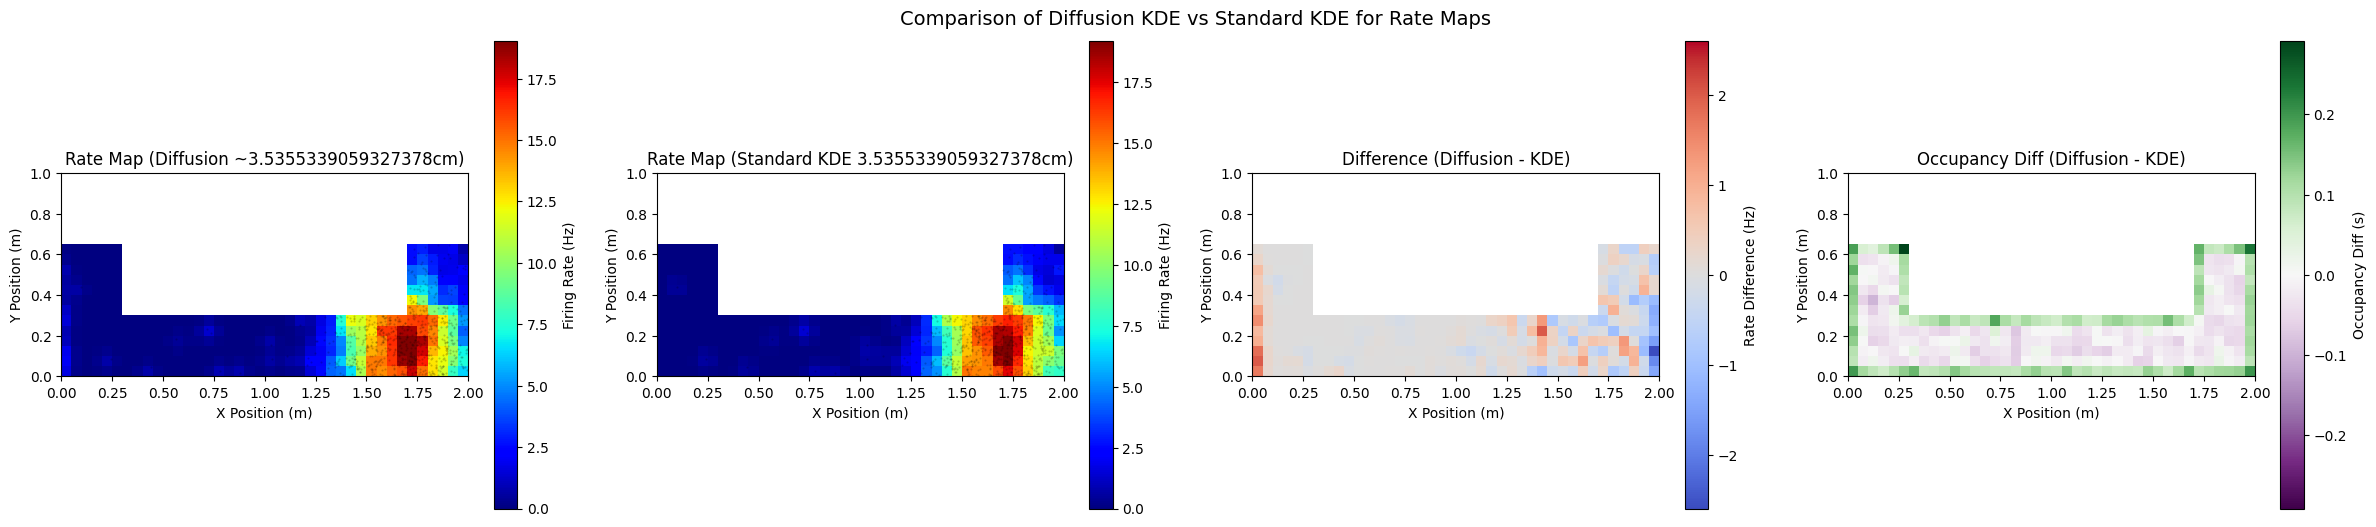

In [ ]:
from sklearn.neighbors import KernelDensity


def calculate_rate_map_kde_sklearn(
    spike_pos_xy: np.ndarray,
    occupancy_pos_xy: np.ndarray,
    x_edges: np.ndarray,
    y_edges: np.ndarray,
    interior_mask: np.ndarray,
    fs: float,
    grid_shape: Tuple[int, int],
    sigma_m: float,  # Gaussian kernel std dev in METERS
    epsilon: float = 1e-9,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Calculates a firing rate map using standard Gaussian KDE (sklearn).

    Note: This method does not explicitly handle boundaries and may show
          bias (underestimation) near the edges of the sampled area.

    Args:
        spike_pos_xy: (N, 2) numpy array of spike (x, y) coordinates (in meters).
        occupancy_pos_xy: (M, 2) numpy array of all position sample (x, y) coordinates (in meters).
        x_edges: 1D numpy array of x bin edges.
        y_edges: 1D numpy array of y bin edges.
        interior_mask: Boolean grid mask (True=inside track), shape (n_bins_y, n_bins_x).
        fs: Position sampling rate (Hz).
        grid_shape: Tuple (n_bins_y, n_bins_x).
        sigma_m: Standard deviation of the Gaussian kernel in meters. This is the bandwidth 'h'.
        epsilon: Small value to prevent division by zero. Defaults to 1e-9.

    Returns:
        A tuple containing NumPy arrays:
            - firing_rate_map (Hz)
            - kde_spike_counts (smoothed spike counts)
            - kde_occupancy_time (smoothed occupancy time in seconds)
    """
    n_bins_y, n_bins_x = grid_shape
    n_pos_samples = occupancy_pos_xy.shape[0]
    n_spikes = spike_pos_xy.shape[0]

    if n_pos_samples == 0:
        print("Warning: No occupancy samples provided for KDE.")
        zeros = np.zeros(grid_shape)
        return zeros, zeros, zeros

    # Calculate grid cell centers for KDE evaluation
    grid_x_centers = (x_edges[:-1] + x_edges[1:]) / 2
    grid_y_centers = (y_edges[:-1] + y_edges[1:]) / 2
    grid_xx, grid_yy = np.meshgrid(grid_x_centers, grid_y_centers)
    # Shape needed for score_samples: (n_evaluation_points, n_features=2)
    grid_coords_eval = np.vstack([grid_xx.ravel(), grid_yy.ravel()]).T

    # --- Occupancy KDE ---
    print("Fitting Occupancy KDE...")
    kde_occ = KernelDensity(kernel="gaussian", bandwidth=sigma_m)
    kde_occ.fit(occupancy_pos_xy)
    print("Evaluating Occupancy KDE...")
    log_density_occ = kde_occ.score_samples(grid_coords_eval)
    occupancy_density = np.exp(log_density_occ).reshape(grid_shape)
    # Normalize density: Sum(density * area) should be ~1
    # Scale to get time density: time_density = density * total_time
    # Total time = n_pos_samples / fs
    total_time_seconds = n_pos_samples / fs
    # Normalize carefully: sum of density * area should approx 1
    # cell_area = (x_edges[1]-x_edges[0]) * (y_edges[1]-y_edges[0])
    # norm_factor_occ = np.sum(occupancy_density * cell_area) # Normalization constant
    # kde_occupancy_time = (occupancy_density / (norm_factor_occ + epsilon)) * total_time_seconds
    # Simpler approx: scale proportionally
    kde_occupancy_time = occupancy_density * (
        total_time_seconds / (np.sum(occupancy_density) + epsilon)
    )
    print("Occupancy KDE done.")

    # --- Spike KDE ---
    if n_spikes > 1:  # Need at least 2 points for KDE typically
        print("Fitting Spike KDE...")
        kde_spk = KernelDensity(kernel="gaussian", bandwidth=sigma_m)
        kde_spk.fit(spike_pos_xy)
        print("Evaluating Spike KDE...")
        log_density_spk = kde_spk.score_samples(grid_coords_eval)
        spike_density = np.exp(log_density_spk).reshape(grid_shape)
        # Scale to get spike counts: counts = density * total_spikes
        # norm_factor_spk = np.sum(spike_density * cell_area)
        # kde_spike_counts = (spike_density / (norm_factor_spk + epsilon)) * n_spikes
        kde_spike_counts = spike_density * (
            n_spikes / (np.sum(spike_density) + epsilon)
        )
        print("Spike KDE done.")
    else:
        print("Warning: Not enough spikes (<2) for KDE. Returning zero spike map.")
        kde_spike_counts = np.zeros(grid_shape)

    # --- Calculate Firing Rate ---
    # Ensure occupancy time isn't negative
    safe_occupancy_time = np.maximum(kde_occupancy_time, 0.0)
    firing_rate_map = kde_spike_counts / (safe_occupancy_time + epsilon)
    # Mask result to only include track interior
    firing_rate_map *= interior_mask

    return firing_rate_map, kde_spike_counts, kde_occupancy_time


# --- Example Usage ---

if __name__ == "__main__":
    # Use NumPy for data generation, then pass to the JAX function
    np.random.seed(42)

    # --- 1. Define Grid and Track Mask ---
    GRID_RESOLUTION_M_PER_BIN = 0.05
    X_MIN, X_MAX = 0, 2
    Y_MIN, Y_MAX = 0, 1
    n_bins_x = int((X_MAX - X_MIN) / GRID_RESOLUTION_M_PER_BIN)
    n_bins_y = int((Y_MAX - Y_MIN) / GRID_RESOLUTION_M_PER_BIN)
    grid_shape = (n_bins_y, n_bins_x)
    x_edges_np = np.linspace(X_MIN, X_MAX, n_bins_x + 1)
    y_edges_np = np.linspace(Y_MIN, Y_MAX, n_bins_y + 1)
    bin_centers_x_np = (x_edges_np[:-1] + x_edges_np[1:]) / 2
    bin_centers_y_np = (y_edges_np[:-1] + y_edges_np[1:]) / 2
    bin_centers_xx_np, bin_centers_yy_np = np.meshgrid(
        bin_centers_x_np, bin_centers_y_np
    )
    TRACK_WIDTH_M = 0.3
    is_bottom_arm = np.abs(bin_centers_yy_np - TRACK_WIDTH_M / 2) < TRACK_WIDTH_M / 2
    is_left_arm = np.abs(bin_centers_xx_np - TRACK_WIDTH_M / 2) < TRACK_WIDTH_M / 2
    is_right_arm = (
        np.abs(bin_centers_xx_np - (X_MAX - TRACK_WIDTH_M / 2)) < TRACK_WIDTH_M / 2
    )
    is_track_interior_np = is_bottom_arm | is_left_arm | is_right_arm
    is_top_part = bin_centers_yy_np > (Y_MAX - TRACK_WIDTH_M * 1.1)
    remove_mask = (is_left_arm & is_top_part) | (is_right_arm & is_top_part)
    is_track_interior_np[remove_mask] = False

    # --- 2. Generate Dummy Positional Data ---
    DURATION_SECONDS = 180
    FS_HZ = 30
    N_POS_SAMPLES = int(DURATION_SECONDS * FS_HZ)
    N_INITIAL_POINTS = N_POS_SAMPLES * 10  # Increased initial points slightly
    initial_animal_positions_np = np.random.rand(N_INITIAL_POINTS, 2) * np.array(
        [X_MAX, Y_MAX]
    )
    pos_indices_x = np.digitize(initial_animal_positions_np[:, 0], x_edges_np[1:-1])
    pos_indices_y = np.digitize(initial_animal_positions_np[:, 1], y_edges_np[1:-1])
    pos_indices_x = np.clip(pos_indices_x, 0, n_bins_x - 1)
    pos_indices_y = np.clip(pos_indices_y, 0, n_bins_y - 1)
    track_mask_flat = is_track_interior_np[pos_indices_y, pos_indices_x]
    animal_positions_np = initial_animal_positions_np[track_mask_flat][:N_POS_SAMPLES]
    position_timestamps_np = np.linspace(
        0, len(animal_positions_np) / FS_HZ, len(animal_positions_np)
    )
    if len(animal_positions_np) < N_POS_SAMPLES:
        print(f"Warning: Only kept {len(animal_positions_np)} samples.")
    else:
        print(f"Kept {len(animal_positions_np)} position samples within the track.")

    # --- 3. Generate Dummy Spike Data ---
    PLACE_FIELD_CENTER_M = np.array([X_MAX - TRACK_WIDTH_M, TRACK_WIDTH_M / 2])
    PLACE_FIELD_RADIUS_M = 0.2
    BASE_FIRING_RATE_HZ = 0.1
    PEAK_FIRING_RATE_HZ = 20.0
    distances_m = np.linalg.norm(animal_positions_np - PLACE_FIELD_CENTER_M, axis=1)
    prob_spike = BASE_FIRING_RATE_HZ / FS_HZ + (PEAK_FIRING_RATE_HZ / FS_HZ) * np.exp(
        -(distances_m**2) / (2 * PLACE_FIELD_RADIUS_M**2)
    )
    spike_flags = np.random.rand(len(animal_positions_np)) < prob_spike
    spike_times_np = position_timestamps_np[spike_flags]
    spike_positions_np = animal_positions_np[spike_flags, :]
    print(f"Generated {len(spike_positions_np)} spikes.")

    # --- 4. Set Smoothing Parameter ---
    # SIGMA_CM = 5.0  # Target Gaussian sigma in cm for smoothing
    SIGMA_M = SIGMA_CM / 100.0  # Convert to meters for KDE function

    # --- 5. Run Diffusion Calculation ---
    print("\nCalculating rate map (Diffusion method)...")
    rate_map_diff, diffused_spikes, diffused_occupancy = (
        calculate_rate_map_diffusion_jax(
            spike_positions_np,
            animal_positions_np,
            x_edges_np,
            y_edges_np,
            is_track_interior_np,
            fs=FS_HZ,
            grid_shape=grid_shape,
            grid_res=GRID_RESOLUTION_M_PER_BIN,
            sigma_cm=SIGMA_CM,
            dt_stability_factor=0.2,
            verbose=True,
        )
    )
    rate_map_diff_np = np.array(rate_map_diff)  # Convert JAX array to NumPy

    # --- 6. Run Standard KDE Calculation ---
    print("\nCalculating rate map (Standard KDE method)...")
    rate_map_kde_np, _, _ = calculate_rate_map_kde_sklearn(
        spike_positions_np,
        animal_positions_np,
        x_edges_np,
        y_edges_np,
        is_track_interior_np,
        fs=FS_HZ,
        grid_shape=grid_shape,
        sigma_m=SIGMA_M,
    )

    # --- 7. Calculate Difference ---
    # Calculate difference only where both maps are potentially valid (inside track)
    difference_map = np.full(grid_shape, np.nan)
    difference_map[is_track_interior_np] = (
        rate_map_diff_np[is_track_interior_np] - rate_map_kde_np[is_track_interior_np]
    )

    # --- 8. Plotting Comparison ---
    print("\nPlotting results...")
    # Increase figure width to accommodate more plots
    plt.figure(figsize=(24, 5.5))  # Adjusted size

    # --- Plot 1: Diffusion Rate Map ---
    plt.subplot(1, 4, 1)
    plot_rate_diff = np.where(is_track_interior_np, rate_map_diff_np, np.nan)
    valid_rates_diff = plot_rate_diff[~np.isnan(plot_rate_diff)]
    vmax_diff = (
        np.percentile(valid_rates_diff, 99) if valid_rates_diff.size > 0 else 1.0
    )
    vmax_diff = max(vmax_diff, 1.0)
    pcm1 = plt.pcolormesh(
        x_edges_np,
        y_edges_np,
        plot_rate_diff,
        shading="auto",
        cmap="jet",
        vmin=0,
        vmax=vmax_diff,
    )
    plt.colorbar(pcm1, label="Firing Rate (Hz)")
    plt.plot(
        spike_positions_np[:, 0],
        spike_positions_np[:, 1],
        "k.",
        markersize=1,
        alpha=0.2,
    )
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Rate Map (Diffusion ~{SIGMA_CM}cm)")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)

    # --- Plot 2: Standard KDE Rate Map ---
    plt.subplot(1, 4, 2)
    plot_rate_kde = np.where(is_track_interior_np, rate_map_kde_np, np.nan)
    valid_rates_kde = plot_rate_kde[~np.isnan(plot_rate_kde)]
    vmax_kde = np.percentile(valid_rates_kde, 99) if valid_rates_kde.size > 0 else 1.0
    vmax_kde = max(vmax_kde, 1.0)
    # Use same vmax as diffusion plot for direct comparison, or calculate independently
    vmax_compare = max(vmax_diff, vmax_kde)  # Use a common scale
    pcm2 = plt.pcolormesh(
        x_edges_np,
        y_edges_np,
        plot_rate_kde,
        shading="auto",
        cmap="jet",
        vmin=0,
        vmax=vmax_compare,
    )
    plt.colorbar(pcm2, label="Firing Rate (Hz)")
    plt.plot(
        spike_positions_np[:, 0],
        spike_positions_np[:, 1],
        "k.",
        markersize=1,
        alpha=0.2,
    )
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Rate Map (Standard KDE {SIGMA_CM}cm)")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)

    # --- Plot 3: Difference Map (Diffusion - KDE) ---
    plt.subplot(1, 4, 3)
    # Center the colormap around zero
    diff_max_abs = np.nanmax(np.abs(difference_map))
    diff_max_abs = max(diff_max_abs, 1e-6)  # Ensure non-zero limit
    pcm3 = plt.pcolormesh(
        x_edges_np,
        y_edges_np,
        difference_map,
        shading="auto",
        cmap="coolwarm",
        vmin=-diff_max_abs,
        vmax=diff_max_abs,
    )
    plt.colorbar(pcm3, label="Rate Difference (Hz)")
    # Overlay the track boundary for context (optional)
    # You might need to calculate boundary points more explicitly
    # plt.contour(bin_centers_x_np, bin_centers_y_np, is_track_interior_np.astype(float), levels=[0.5], colors='black', linewidths=0.5)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title("Difference (Diffusion - KDE)")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)

    # --- Plot 4: Occupancy Comparison (Optional but informative) ---
    plt.subplot(1, 4, 4)
    # Get KDE occupancy (convert JAX array first)
    _, _, kde_occupancy_time_np = calculate_rate_map_kde_sklearn(
        spike_positions_np,
        animal_positions_np,
        x_edges_np,
        y_edges_np,
        is_track_interior_np,
        FS_HZ,
        grid_shape,
        SIGMA_M,
    )
    diffused_occupancy_np = np.array(diffused_occupancy)  # Convert JAX array
    occ_difference = np.full(grid_shape, np.nan)
    occ_difference[is_track_interior_np] = (
        diffused_occupancy_np[is_track_interior_np]
        - kde_occupancy_time_np[is_track_interior_np]
    )
    occ_diff_max_abs = np.nanmax(np.abs(occ_difference))
    occ_diff_max_abs = max(occ_diff_max_abs, 1e-9)
    pcm4 = plt.pcolormesh(
        x_edges_np,
        y_edges_np,
        occ_difference,
        shading="auto",
        cmap="PRGn",
        vmin=-occ_diff_max_abs,
        vmax=occ_diff_max_abs,
    )  # Purple-Green colormap
    plt.colorbar(pcm4, label="Occupancy Diff (s)")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title("Occupancy Diff (Diffusion - KDE)")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout slightly for suptitle
    plt.suptitle(
        "Comparison of Diffusion KDE vs Standard KDE for Rate Maps", fontsize=14
    )
    plt.show()

In [ ]:
from non_local_detector import Environment

import jax
import jax.numpy as jnp
from jax import jit
from functools import partial
import numpy as np
import math  # Use standard math for n_steps calculation
import matplotlib.pyplot as plt
import time  # For timing JIT
from typing import Tuple, Union  # Added Union for potential future use

# Assume the Environment class and its dependencies (get_centers, get_grid, etc.)
# are defined in a separate file (e.g., environment_utils.py) or directly above.
# from environment_utils import Environment, get_centers, get_grid # Example import


# --- Diffusion Simulation Helper Functions ---
# [PASTE THE CLEANED HELPER FUNCTIONS HERE: map_points_to_grid,
#  calculate_laplacian_neumann, diffusion_step, run_diffusion]
@partial(jit, static_argnames=["grid_shape"])
def map_points_to_grid(
    points_xy: jnp.ndarray,
    x_edges: jnp.ndarray,
    y_edges: jnp.ndarray,
    grid_shape: Tuple[int, int],
) -> jnp.ndarray:
    n_bins_y, n_bins_x = grid_shape
    x_indices = jnp.digitize(points_xy[:, 0], x_edges[1:-1])
    y_indices = jnp.digitize(points_xy[:, 1], y_edges[1:-1])
    x_indices = jnp.clip(x_indices, 0, n_bins_x - 1)
    y_indices = jnp.clip(y_indices, 0, n_bins_y - 1)
    initial_counts = jnp.zeros(grid_shape, dtype=jnp.float32)
    try:
        initial_counts = jax.ops.index_add(
            initial_counts, jax.ops.index[y_indices, x_indices], 1.0
        )
    except AttributeError:
        initial_counts = initial_counts.at[y_indices, x_indices].add(1.0)
    return initial_counts


@jit
def calculate_laplacian_neumann(
    grid: jnp.ndarray, interior_mask: jnp.ndarray
) -> jnp.ndarray:
    gw = jnp.roll(grid, shift=1, axis=1)
    ge = jnp.roll(grid, shift=-1, axis=1)
    gs = jnp.roll(grid, shift=1, axis=0)
    gn = jnp.roll(grid, shift=-1, axis=0)
    mask_w = jnp.roll(interior_mask, shift=1, axis=1)
    mask_e = jnp.roll(interior_mask, shift=-1, axis=1)
    mask_s = jnp.roll(interior_mask, shift=1, axis=0)
    mask_n = jnp.roll(interior_mask, shift=-1, axis=0)
    gw = jnp.where(mask_w, gw, grid)
    ge = jnp.where(mask_e, ge, grid)
    gs = jnp.where(mask_s, gs, grid)
    gn = jnp.where(mask_n, gn, grid)
    lap_x = gw + ge - 2 * grid
    lap_y = gs + gn - 2 * grid
    return (lap_x + lap_y) * interior_mask


@partial(jit, static_argnames=["D_sim", "dt"])
def diffusion_step(
    grid: jnp.ndarray, D_sim: float, dt: float, interior_mask: jnp.ndarray
) -> jnp.ndarray:
    laplacian = calculate_laplacian_neumann(grid, interior_mask)
    new_grid = grid + dt * D_sim * laplacian
    return new_grid * interior_mask


@partial(jit, static_argnames=["n_steps", "D_sim", "dt"])
def run_diffusion(
    initial_grid: jnp.ndarray,
    n_steps: int,
    D_sim: float,
    dt: float,
    interior_mask: jnp.ndarray,
) -> jnp.ndarray:
    def scan_step(current_grid, _):
        next_grid = diffusion_step(current_grid, D_sim, dt, interior_mask)
        return next_grid, None

    final_grid, _ = jax.lax.scan(scan_step, initial_grid, xs=None, length=n_steps)
    return final_grid


# --- Main Internal JIT-Compiled Calculation Function ---
# [PASTE THE CLEANED INTERNAL FUNCTION HERE: calculate_rate_map_diffusion_jax_internal]
@partial(jit, static_argnames=["grid_shape", "fs", "D_sim", "dt", "n_steps"])
def calculate_rate_map_diffusion_jax_internal(
    spike_pos_xy: jnp.ndarray,
    occupancy_pos_xy: jnp.ndarray,
    x_edges: jnp.ndarray,
    y_edges: jnp.ndarray,
    interior_mask: jnp.ndarray,
    fs: float,
    grid_shape: Tuple[int, int],
    D_sim: float,
    dt: float,
    n_steps: int,
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    n_bins_y, n_bins_x = grid_shape
    initial_spike_counts = map_points_to_grid(
        spike_pos_xy, x_edges, y_edges, grid_shape
    )
    initial_occupancy_counts = map_points_to_grid(
        occupancy_pos_xy, x_edges, y_edges, grid_shape
    )
    initial_spike_counts *= interior_mask
    initial_occupancy_counts *= interior_mask
    diffused_spikes = run_diffusion(
        initial_spike_counts, n_steps, D_sim, dt, interior_mask
    )
    diffused_occupancy = run_diffusion(
        initial_occupancy_counts, n_steps, D_sim, dt, interior_mask
    )
    total_occupancy_counts_in = jnp.sum(initial_occupancy_counts)
    total_spikes_in = jnp.sum(initial_spike_counts)
    total_time_seconds = total_occupancy_counts_in / fs
    sum_diffused_occ = jnp.sum(diffused_occupancy)
    sum_diffused_spk = jnp.sum(diffused_spikes)
    safe_sum_diffused_occ = sum_diffused_occ + 1e-12
    safe_sum_diffused_spk = sum_diffused_spk + 1e-12
    diffused_occupancy_time = (
        diffused_occupancy / safe_sum_diffused_occ
    ) * total_time_seconds
    diffused_spike_counts_scaled = jnp.where(
        total_spikes_in > 0,
        (diffused_spikes / safe_sum_diffused_spk) * total_spikes_in,
        jnp.zeros_like(diffused_spikes),
    )
    epsilon = 1e-9
    safe_occupancy_time = jnp.maximum(diffused_occupancy_time, 0.0)
    firing_rate_map = diffused_spike_counts_scaled / (safe_occupancy_time + epsilon)
    firing_rate_map *= interior_mask
    return firing_rate_map, diffused_spike_counts_scaled, diffused_occupancy_time


# --- User-Facing Wrapper Function ---
# [PASTE THE CLEANED WRAPPER FUNCTION HERE: calculate_rate_map_diffusion_jax]
def calculate_rate_map_diffusion_jax(
    spike_pos_xy: Union[np.ndarray, jnp.ndarray],
    occupancy_pos_xy: Union[np.ndarray, jnp.ndarray],
    x_edges: Union[np.ndarray, jnp.ndarray],
    y_edges: Union[np.ndarray, jnp.ndarray],
    interior_mask: Union[np.ndarray, jnp.ndarray],
    fs: float,
    grid_shape: Tuple[int, int],
    grid_res: float,
    sigma_cm: float = 5.0,
    dt_stability_factor: float = 0.2,
    verbose: bool = True,
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    if sigma_cm <= 0:
        raise ValueError("sigma_cm must be positive")
        CM_PER_METER = 100.0
        res_cm = grid_res * CM_PER_METER
        sigma_bins = sigma_cm / res_cm
        D_sim = 1.0
        T_sim = (sigma_bins**2) / (2.0 * D_sim)
        max_stable_dt = 1.0 / (4.0 * D_sim)
        dt = float(dt_stability_factor * max_stable_dt)
        n_steps = max(1, math.ceil(T_sim / dt))
    if verbose:
        print(
            f"Target sigma={sigma_cm:.2f} cm ({sigma_bins:.2f} bins). Using D_sim={D_sim:.1f} bins^2/unit_time."
        )
        print(
            f"Required T_sim={T_sim:.2f} unit_time. Calculated dt={dt:.4f}, N_steps={n_steps}"
        )
    fs_static = float(fs)
    static_args_for_internal = {
        "fs": fs_static,
        "grid_shape": grid_shape,
        "D_sim": D_sim,
        "dt": dt,
        "n_steps": n_steps,
    }
    compiled_internal_func = jit(
        partial(calculate_rate_map_diffusion_jax_internal, **static_args_for_internal)
    )
    start_time = time.time()
    result = compiled_internal_func(
        jnp.asarray(spike_pos_xy),
        jnp.asarray(occupancy_pos_xy),
        jnp.asarray(x_edges),
        jnp.asarray(y_edges),
        jnp.asarray(interior_mask, dtype=bool),
    )
    result[0].block_until_ready()
    end_time = time.time()
    if verbose:
        print(f"JAX calculation took: {end_time - start_time:.4f} seconds")
    return result


# --- Example Usage ---

if __name__ == "__main__":
    # Use NumPy for data generation, then pass to the JAX function
    np.random.seed(42)

    # --- 1. Define Grid and Simulation Parameters ---
    GRID_RESOLUTION_M_PER_BIN = 0.05  # meters per bin
    X_MIN, X_MAX = 0, 2
    Y_MIN, Y_MAX = 0, 1
    POSITION_RANGE = [(X_MIN, X_MAX), (Y_MIN, Y_MAX)]  # Define position range

    DURATION_SECONDS = 180
    FS_HZ = 30  # Sampling rate (Hz)

    SIGMA_CM = 5.0  # Target Gaussian sigma in cm for smoothing

    # --- 2. Generate Dummy Positional Data ---
    N_POS_SAMPLES = int(DURATION_SECONDS * FS_HZ)
    N_INITIAL_POINTS = N_POS_SAMPLES * 10  # Generate more points for rejection sampling

    # Create plausible random walk data first (might wander outside track initially)
    # This data will be used to *fit* the environment's grid and interior mask
    rw_positions = np.random.rand(N_INITIAL_POINTS, 2) * np.array([X_MAX, Y_MAX])
    # Apply some smoothing or realistic movement model if needed,
    # but simple random is okay for fitting the grid extent.

    # --- 3. Create and Fit Environment using the Environment Class ---
    print("\nFitting Environment grid...")
    environment = Environment(
        place_bin_size=GRID_RESOLUTION_M_PER_BIN,
        position_range=POSITION_RANGE,
        infer_track_interior=True,  # Infer from positions
        bin_count_threshold=0,  # Consider bin occupied if >0 samples fall in it
        fill_holes=True,  # Optional: Fill small holes in mask
        dilate=False,  # Optional: Expand mask slightly
    )
    # Fit the environment using the generated position data
    # NOTE: fit_place_grid needs position data to infer grid and potentially interior
    environment.fit_place_grid(position=rw_positions)
    print("Environment fitting complete.")

    # --- Extract necessary parameters from environment ---
    x_edges_np = environment.edges_[0]
    y_edges_np = environment.edges_[1]
    # Ensure the interior mask is boolean
    is_track_interior_np = environment.is_track_interior_.astype(bool)
    grid_shape = environment.centers_shape_  # Should be (n_bins_y, n_bins_x)

    # --- 4. Generate Realistic Occupancy Data (Confined to Track) ---
    # Now that the track interior is defined, generate occupancy data *within* it.
    print(f"\nGenerating {N_POS_SAMPLES} occupancy samples confined to track...")
    # Efficiently sample points only within the track interior bins
    valid_bin_indices = np.argwhere(
        is_track_interior_np
    )  # Get indices (y, x) of valid bins
    if valid_bin_indices.shape[0] == 0:
        raise ValueError("No valid interior bins found in the environment mask!")
    # Randomly choose valid bins to place points in
    chosen_bin_indices = valid_bin_indices[
        np.random.randint(valid_bin_indices.shape[0], size=N_POS_SAMPLES)
    ]
    # Get center coordinates of chosen bins
    bin_centers_y = (
        y_edges_np[chosen_bin_indices[:, 0]] + y_edges_np[chosen_bin_indices[:, 0] + 1]
    ) / 2
    bin_centers_x = (
        x_edges_np[chosen_bin_indices[:, 1]] + x_edges_np[chosen_bin_indices[:, 1] + 1]
    ) / 2
    # Add small random jitter within the bin for more realistic positions
    jitter_x = (np.random.rand(N_POS_SAMPLES) - 0.5) * GRID_RESOLUTION_M_PER_BIN
    jitter_y = (np.random.rand(N_POS_SAMPLES) - 0.5) * GRID_RESOLUTION_M_PER_BIN
    animal_positions_np = np.stack(
        [bin_centers_x + jitter_x, bin_centers_y + jitter_y], axis=1
    )
    # Ensure points stay roughly within bin edges (optional clipping)
    animal_positions_np[:, 0] = np.clip(animal_positions_np[:, 0], X_MIN, X_MAX)
    animal_positions_np[:, 1] = np.clip(animal_positions_np[:, 1], Y_MIN, Y_MAX)

    # Generate corresponding timestamps
    position_timestamps_np = np.linspace(0, N_POS_SAMPLES / FS_HZ, N_POS_SAMPLES)
    print(
        f"Generated {len(animal_positions_np)} occupancy position samples within the track."
    )

    # --- 5. Generate Dummy Spike Data (Based on confined animal positions) ---
    TRACK_WIDTH_M = 0.3  # Used again for place field definition
    PLACE_FIELD_CENTER_M = np.array([X_MAX - TRACK_WIDTH_M, TRACK_WIDTH_M / 2])
    PLACE_FIELD_RADIUS_M = 0.2
    BASE_FIRING_RATE_HZ = 0.1
    PEAK_FIRING_RATE_HZ = 20.0

    distances_m = np.linalg.norm(animal_positions_np - PLACE_FIELD_CENTER_M, axis=1)
    prob_spike = BASE_FIRING_RATE_HZ / FS_HZ + (PEAK_FIRING_RATE_HZ / FS_HZ) * np.exp(
        -(distances_m**2) / (2 * PLACE_FIELD_RADIUS_M**2)
    )
    spike_flags = np.random.rand(len(animal_positions_np)) < prob_spike
    spike_times_np = position_timestamps_np[spike_flags]
    spike_positions_np = animal_positions_np[spike_flags, :]
    print(f"Generated {len(spike_positions_np)} spikes.")

    # --- 6. Run Diffusion Calculation ---
    print("\nCalculating rate map (Diffusion method)...")
    # Pass NumPy arrays - the wrapper function converts them
    rate_map_diff, diffused_spikes, diffused_occupancy = (
        calculate_rate_map_diffusion_jax(
            spike_positions_np,
            animal_positions_np,
            x_edges_np,
            y_edges_np,
            is_track_interior_np,
            fs=FS_HZ,
            grid_shape=grid_shape,
            grid_res=GRID_RESOLUTION_M_PER_BIN,
            sigma_cm=SIGMA_CM,
            dt_stability_factor=0.2,
            verbose=True,
        )
    )
    # Convert results to NumPy for plotting/further analysis if needed
    rate_map_diff_np = np.array(rate_map_diff)
    diffused_spikes_np = np.array(diffused_spikes)
    diffused_occupancy_np = np.array(diffused_occupancy)

    # --- 7. Plotting ---
    print("\nPlotting results...")
    plt.figure(figsize=(12, 5.5))  # Adjusted size for fewer plots initially

    # Subplot 1: Diffusion Rate Map
    plt.subplot(1, 2, 1)  # Changed subplot index
    plot_rate_diff = np.where(is_track_interior_np, rate_map_diff_np, np.nan)
    valid_rates_diff = plot_rate_diff[~np.isnan(plot_rate_diff)]
    if valid_rates_diff.size > 0:
        vmax_diff = np.percentile(valid_rates_diff, 99)
    else:
        print("Warning: No valid diffusion rate values found for vmax calculation.")
        vmax_diff = 1.0
    vmax_diff = max(vmax_diff, 1.0)

    pcm1 = plt.pcolormesh(
        x_edges_np,
        y_edges_np,
        plot_rate_diff,
        shading="auto",
        cmap="jet",
        vmin=0,
        vmax=vmax_diff,
    )
    plt.colorbar(pcm1, label="Firing Rate (Hz)")
    plt.plot(
        spike_positions_np[:, 0],
        spike_positions_np[:, 1],
        "k.",
        markersize=1,
        alpha=0.2,
    )
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Rate Map (Diffusion ~{SIGMA_CM}cm)")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)

    # Subplot 2: Track Interior from Environment Class
    plt.subplot(1, 2, 2)  # Changed subplot index
    plt.pcolormesh(
        x_edges_np,
        y_edges_np,
        is_track_interior_np.astype(float),
        cmap="binary",
        vmin=0,
        vmax=1,
    )
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title("Environment Track Interior")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
    plt.suptitle("Diffusion Rate Map Calculated using Environment Grid", fontsize=14)
    plt.show()

/Users/edeno/miniconda3/envs/non_local_detector2/lib/python3.12/site-packages/non_local_detector/likelihoods/clusterless_kde.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



Fitting Environment grid...
Environment fitting complete.

Generating 5400 occupancy samples confined to track...


IndexError: index 34 is out of bounds for axis 0 with size 23

Generating initial data for environment fitting...

Fitting Environment grid...
Using manual grid definition for example...
Environment fitting complete.
Grid shape: (20, 40)

Calculating simulation parameters...
Target sigma=5.00 cm (1.00 bins). Using D_sim=1.0 bins^2/unit_time.
Required T_sim=0.50 unit_time. Calculated dt=0.0500, N_steps=10
Starting diffusion kernel precomputation...
  Running 324 diffusion simulations via vmap (will JIT compile internal function)...
Kernel precomputation took: 0.1091 seconds
  Kernel Matrix shape: (800, 324), Memory: 0.001 GB

Generating occupancy samples confined to track...
Generated 5400 occupancy position samples within the track.

Generating spikes for 10 neurons...
  Neuron 1: Generated 607 spikes.
  Neuron 2: Generated 606 spikes.
  Neuron 3: Generated 408 spikes.
  Neuron 4: Generated 526 spikes.
  Neuron 5: Generated 728 spikes.
  Neuron 6: Generated 554 spikes.
  Neuron 7: Generated 914 spikes.
  Neuron 8: Generated 597 spikes.
  Neuron 9:

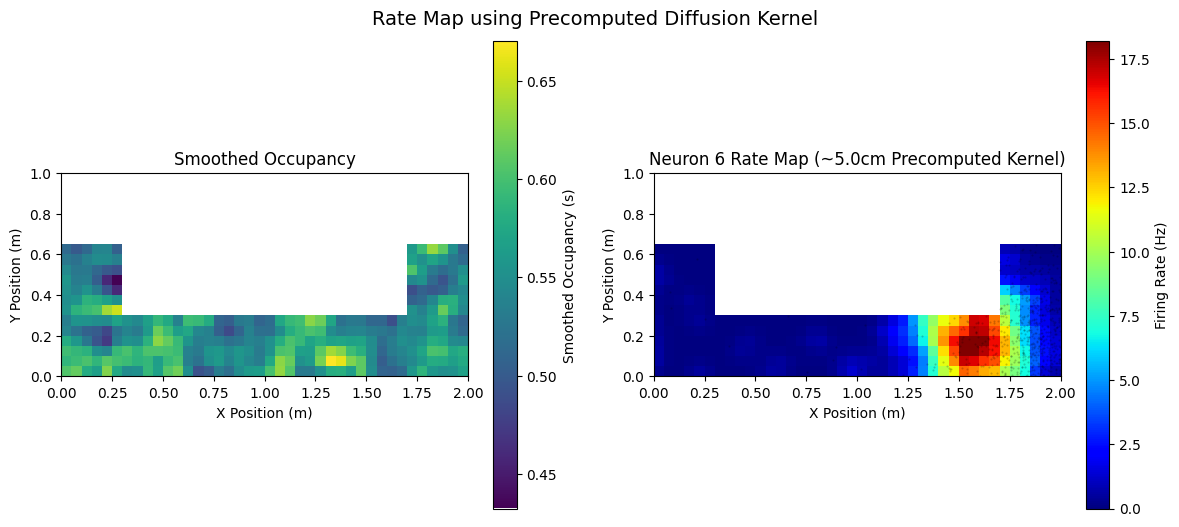

In [18]:
import time
import math
from functools import partial
from typing import Tuple, Union, Dict

import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import numpy as np

# Import for standard KDE comparison if used later
# from sklearn.neighbors import KernelDensity
# Assume Environment class is defined elsewhere or pasted above
# from environment_utils import Environment # Example


# --- Diffusion Simulation Helper Functions ---
# [map_points_to_grid, calculate_laplacian_neumann remain unchanged]
@partial(jit, static_argnames=["grid_shape"])
def map_points_to_grid(
    points_xy: jnp.ndarray,
    x_edges: jnp.ndarray,
    y_edges: jnp.ndarray,
    grid_shape: Tuple[int, int],
) -> jnp.ndarray:
    n_bins_y, n_bins_x = grid_shape
    x_indices = jnp.digitize(points_xy[:, 0], x_edges[1:-1])
    y_indices = jnp.digitize(points_xy[:, 1], y_edges[1:-1])
    x_indices = jnp.clip(x_indices, 0, n_bins_x - 1)
    y_indices = jnp.clip(y_indices, 0, n_bins_y - 1)
    initial_counts = jnp.zeros(grid_shape, dtype=jnp.float32)
    try:
        initial_counts = jax.ops.index_add(
            initial_counts, jax.ops.index[y_indices, x_indices], 1.0
        )
    except AttributeError:
        initial_counts = initial_counts.at[y_indices, x_indices].add(1.0)
    return initial_counts


@jit
def calculate_laplacian_neumann(
    grid: jnp.ndarray, interior_mask: jnp.ndarray
) -> jnp.ndarray:
    gw = jnp.roll(grid, shift=1, axis=1)
    ge = jnp.roll(grid, shift=-1, axis=1)
    gs = jnp.roll(grid, shift=1, axis=0)
    gn = jnp.roll(grid, shift=-1, axis=0)
    mask_w = jnp.roll(interior_mask, shift=1, axis=1)
    mask_e = jnp.roll(interior_mask, shift=-1, axis=1)
    mask_s = jnp.roll(interior_mask, shift=1, axis=0)
    mask_n = jnp.roll(interior_mask, shift=-1, axis=0)
    gw = jnp.where(mask_w, gw, grid)
    ge = jnp.where(mask_e, ge, grid)
    gs = jnp.where(mask_s, gs, grid)
    gn = jnp.where(mask_n, gn, grid)
    lap_x = gw + ge - 2 * grid
    lap_y = gs + gn - 2 * grid
    return (lap_x + lap_y) * interior_mask


@partial(jit, static_argnames=["D_sim", "dt"])
def diffusion_step(
    grid: jnp.ndarray, D_sim: float, dt: float, interior_mask: jnp.ndarray
) -> jnp.ndarray:
    laplacian = calculate_laplacian_neumann(grid, interior_mask)
    new_grid = grid + dt * D_sim * laplacian
    return new_grid * interior_mask


@partial(jit, static_argnames=["n_steps", "D_sim", "dt"])
def run_diffusion(
    initial_grid: jnp.ndarray,
    n_steps: int,
    D_sim: float,
    dt: float,
    interior_mask: jnp.ndarray,
) -> jnp.ndarray:
    def scan_step(current_grid, _):
        next_grid = diffusion_step(current_grid, D_sim, dt, interior_mask)
        return next_grid, None

    final_grid, _ = jax.lax.scan(scan_step, initial_grid, xs=None, length=n_steps)
    return final_grid


# --- NEW: Precomputation and Application Functions ---


# ***** CHANGE: Added JIT decorator with static_argnames *****
@partial(jit, static_argnames=["grid_shape", "n_steps", "D_sim", "dt"])
def _run_diffusion_from_source(
    source_y_idx: int,  # Dynamic input for vmap
    source_x_idx: int,  # Dynamic input for vmap
    # Static arguments below (broadcasted by vmap using None in in_axes)
    grid_shape: Tuple[int, int],
    n_steps: int,
    D_sim: float,
    dt: float,
    interior_mask: jnp.ndarray,  # Remains a JAX array, used dynamically inside
) -> jnp.ndarray:
    """Helper: Runs diffusion from a single source bin, returns flattened result.
    JIT compiled, grid_shape/n_steps/D_sim/dt must be static."""
    # grid_shape is now static, so jnp.zeros knows the shape at compile time
    initial_grid = (
        jnp.zeros(grid_shape, dtype=jnp.float32).at[source_y_idx, source_x_idx].set(1.0)
    )
    initial_grid *= interior_mask  # Ensure source is valid
    final_grid = run_diffusion(initial_grid, n_steps, D_sim, dt, interior_mask)
    return final_grid.ravel()


# ***********************************************************


def precompute_diffusion_kernel(
    grid_shape: Tuple[int, int],
    interior_mask: Union[np.ndarray, jnp.ndarray],
    D_sim: float,
    dt: float,
    n_steps: int,
    verbose: bool = True,
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Precomputes the diffusion kernel matrix using jax.vmap."""
    if verbose:
        print("Starting diffusion kernel precomputation...")
    start_time = time.time()

    interior_mask_jax = jnp.asarray(interior_mask, dtype=bool)
    if interior_mask_jax.shape != grid_shape:
        raise ValueError(
            f"Shape mismatch: grid_shape={grid_shape}, interior_mask shape={interior_mask.shape}"
        )

    # Find the 2D indices (y, x) of valid interior bins
    # Use size=interior_mask_jax.sum() for static shape guarantee needed by JIT sometimes
    valid_indices_yx = jnp.argwhere(
        interior_mask_jax, size=interior_mask_jax.sum(), fill_value=-1
    )
    # Filter out potential fill_values if mask is not full (although argwhere shouldn't need fill_value here?)
    valid_indices_yx = valid_indices_yx[valid_indices_yx[:, 0] != -1]  # Basic check

    if valid_indices_yx.shape[0] == 0:
        raise ValueError("No valid interior bins found in the provided mask.")

    # Vectorize the simulation function over the source coordinates (y, x)
    # Arguments for vmap correspond to _run_diffusion_from_source:
    # (source_y, source_x, grid_shape, n_steps, D_sim, dt, interior_mask)
    # Map over first two (y, x), broadcast the rest (None)
    vmapped_diffusion = jax.vmap(
        _run_diffusion_from_source,
        in_axes=(0, 0, None, None, None, None, None),
        out_axes=1,  # Stack results column-wise
    )

    # Define static args tuple for the call
    # Note: _run_diffusion_from_source is already jitted with these being static
    # We pass them as regular args here, vmap broadcasts them.
    sim_args = (grid_shape, n_steps, D_sim, dt, interior_mask_jax)

    # Execute the vectorized computation
    # No need to jit vmapped_diffusion again, as the inner func is jitted.
    print(
        f"  Running {valid_indices_yx.shape[0]} diffusion simulations via vmap (will JIT compile internal function)..."
    )
    Kernel_Matrix_flat_cols = vmapped_diffusion(
        valid_indices_yx[:, 0],  # All source y coords
        valid_indices_yx[:, 1],  # All source x coords
        *sim_args,  # Pass the other args to be broadcasted
    )
    Kernel_Matrix_flat_cols.block_until_ready()  # Wait for computation
    end_time = time.time()

    Kernel_Matrix = Kernel_Matrix_flat_cols

    # Calculate the flat indices corresponding to the valid (y, x) source bins
    valid_bin_indices_flat = jnp.ravel_multi_index(
        (valid_indices_yx[:, 0], valid_indices_yx[:, 1]),
        grid_shape,
        mode="clip",  # Use clip just in case
    )

    if verbose:
        print(f"Kernel precomputation took: {end_time - start_time:.4f} seconds")
        mem_gb = Kernel_Matrix.nbytes / (1024**3)
        print(f"  Kernel Matrix shape: {Kernel_Matrix.shape}, Memory: {mem_gb:.3f} GB")

    return Kernel_Matrix, valid_bin_indices_flat


# [Functions: apply_diffusion_kernel, normalize_density - remain unchanged]
@partial(jit, static_argnames=["grid_shape"])
def apply_diffusion_kernel(
    Kernel_Matrix: jnp.ndarray,
    initial_counts: jnp.ndarray,
    grid_shape: Tuple[int, int],
    valid_bin_indices_flat: jnp.ndarray,
) -> jnp.ndarray:
    n_bins_y, n_bins_x = grid_shape
    initial_counts_flat = initial_counts.ravel()
    valid_initial_counts = initial_counts_flat[valid_bin_indices_flat]
    smoothed_flat = Kernel_Matrix @ valid_initial_counts
    return smoothed_flat.reshape(grid_shape)


@partial(jit, static_argnames=["is_occupancy"])
def normalize_density(
    diffused_map: jnp.ndarray,
    initial_counts_map: jnp.ndarray,
    total_value: float,
    fs: float,
    is_occupancy: bool,
    epsilon: float = 1e-12,
) -> jnp.ndarray:
    total_initial_counts = jnp.sum(initial_counts_map)
    sum_diffused = jnp.sum(diffused_map)
    safe_sum_diffused = sum_diffused + epsilon
    if is_occupancy:
        total_time_seconds = total_initial_counts / jnp.maximum(fs, 1e-9)
        normalized_map = (diffused_map / safe_sum_diffused) * total_time_seconds
        return jnp.maximum(normalized_map, 0.0)
    else:
        normalized_map = jnp.where(
            total_initial_counts > 0,
            (diffused_map / safe_sum_diffused) * total_initial_counts,
            jnp.zeros_like(diffused_map),
        )
        return normalized_map


# --- Main Script Logic (including wrapper and example) ---
# [Wrapper function `calculate_rate_map_diffusion_jax` remains unchanged]
def calculate_rate_map_diffusion_jax(
    spike_pos_xy: Union[np.ndarray, jnp.ndarray],
    occupancy_pos_xy: Union[np.ndarray, jnp.ndarray],
    x_edges: Union[np.ndarray, jnp.ndarray],
    y_edges: Union[np.ndarray, jnp.ndarray],
    interior_mask: Union[np.ndarray, jnp.ndarray],
    fs: float,
    grid_shape: Tuple[int, int],
    grid_res: float,
    sigma_cm: float = 5.0,
    dt_stability_factor: float = 0.2,
    verbose: bool = True,
) -> Tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    if sigma_cm <= 0:
        raise ValueError("sigma_cm must be positive")
        CM_PER_METER = 100.0
        res_cm = grid_res * CM_PER_METER
        sigma_bins = sigma_cm / res_cm
        D_sim = 1.0
        T_sim = (sigma_bins**2) / (2.0 * D_sim)
        max_stable_dt = 1.0 / (4.0 * D_sim)
        dt = float(dt_stability_factor * max_stable_dt)
        n_steps = max(1, math.ceil(T_sim / dt))
    if verbose:
        print(
            f"Target sigma={sigma_cm:.2f} cm ({sigma_bins:.2f} bins). Using D_sim={D_sim:.1f} bins^2/unit_time."
        )
        print(
            f"Required T_sim={T_sim:.2f} unit_time. Calculated dt={dt:.4f}, N_steps={n_steps}"
        )
    fs_static = float(fs)
    static_args_for_internal = {
        "fs": fs_static,
        "grid_shape": grid_shape,
        "D_sim": D_sim,
        "dt": dt,
        "n_steps": n_steps,
    }
    compiled_internal_func = jit(
        partial(calculate_rate_map_diffusion_jax_internal, **static_args_for_internal)
    )
    start_time = time.time()
    result = compiled_internal_func(
        jnp.asarray(spike_pos_xy),
        jnp.asarray(occupancy_pos_xy),
        jnp.asarray(x_edges),
        jnp.asarray(y_edges),
        jnp.asarray(interior_mask, dtype=bool),
    )
    result[0].block_until_ready()
    end_time = time.time()
    if verbose:
        print(f"JAX calculation took: {end_time - start_time:.4f} seconds")
    return result


# [Example usage `if __name__ == "__main__":` block remains largely the same,
#  but uses the precomputation functions]

if __name__ == "__main__":
    np.random.seed(42)

    # --- 1. Define Grid and Simulation Parameters ---
    GRID_RESOLUTION_M_PER_BIN = 0.05
    X_MIN, X_MAX = 0, 2
    Y_MIN, Y_MAX = 0, 1
    POSITION_RANGE = [(X_MIN, X_MAX), (Y_MIN, Y_MAX)]
    DURATION_SECONDS = 180
    FS_HZ = 30
    SIGMA_CM = 5.0
    DT_STABILITY_FACTOR = 0.2
    VERBOSE = True

    # --- 2. Fit Environment & Get Grid Params ---
    print("Generating initial data for environment fitting...")
    N_FIT_POINTS = 20000
    fit_positions_np = np.random.rand(N_FIT_POINTS, 2) * np.array([X_MAX, Y_MAX])
    print("\nFitting Environment grid...")
    # environment = Environment(...) # Assuming Environment class is defined/imported
    # environment.fit_place_grid(position=fit_positions_np)
    # --- Use manual grid def for now if Environment class isn't available ---
    print("Using manual grid definition for example...")
    n_bins_x = int((X_MAX - X_MIN) / GRID_RESOLUTION_M_PER_BIN)
    n_bins_y = int((Y_MAX - Y_MIN) / GRID_RESOLUTION_M_PER_BIN)
    grid_shape = (n_bins_y, n_bins_x)
    x_edges_np = np.linspace(X_MIN, X_MAX, n_bins_x + 1)
    y_edges_np = np.linspace(Y_MIN, Y_MAX, n_bins_y + 1)
    bin_centers_x_np = (x_edges_np[:-1] + x_edges_np[1:]) / 2
    bin_centers_y_np = (y_edges_np[:-1] + y_edges_np[1:]) / 2
    bin_centers_xx_np, bin_centers_yy_np = np.meshgrid(
        bin_centers_x_np, bin_centers_y_np
    )
    TRACK_WIDTH_M = 0.3
    is_bottom_arm = np.abs(bin_centers_yy_np - TRACK_WIDTH_M / 2) < TRACK_WIDTH_M / 2
    is_left_arm = np.abs(bin_centers_xx_np - TRACK_WIDTH_M / 2) < TRACK_WIDTH_M / 2
    is_right_arm = (
        np.abs(bin_centers_xx_np - (X_MAX - TRACK_WIDTH_M / 2)) < TRACK_WIDTH_M / 2
    )
    is_track_interior_np = is_bottom_arm | is_left_arm | is_right_arm
    is_top_part = bin_centers_yy_np > (Y_MAX - TRACK_WIDTH_M * 1.1)
    remove_mask = (is_left_arm & is_top_part) | (is_right_arm & is_top_part)
    is_track_interior_np[remove_mask] = False
    # --- End manual grid def ---
    print("Environment fitting complete.")
    print(f"Grid shape: {grid_shape}")

    # --- 3. Calculate Simulation Parameters ---
    print("\nCalculating simulation parameters...")
    CM_PER_METER = 100.0
    res_cm = GRID_RESOLUTION_M_PER_BIN * CM_PER_METER
    sigma_bins = SIGMA_CM / res_cm
    D_sim = 1.0
    T_sim = (sigma_bins**2) / (2.0 * D_sim)
    max_stable_dt = 1.0 / (4.0 * D_sim)
    dt = float(DT_STABILITY_FACTOR * max_stable_dt)
    n_steps = max(1, math.ceil(T_sim / dt))
    if VERBOSE:
        print(
            f"Target sigma={SIGMA_CM:.2f} cm ({sigma_bins:.2f} bins). Using D_sim={D_sim:.1f} bins^2/unit_time."
        )
        print(
            f"Required T_sim={T_sim:.2f} unit_time. Calculated dt={dt:.4f}, N_steps={n_steps}"
        )

    # --- 4. Precompute Diffusion Kernel ---
    is_track_interior_jax = jnp.asarray(is_track_interior_np)
    Kernel_Matrix, valid_bin_indices_flat = precompute_diffusion_kernel(
        grid_shape, is_track_interior_jax, D_sim, dt, n_steps, verbose=VERBOSE
    )

    # --- 5. Generate Occupancy and Spike Data ---
    print(f"\nGenerating occupancy samples confined to track...")
    N_POS_SAMPLES = int(DURATION_SECONDS * FS_HZ)
    valid_bin_indices_np = np.argwhere(is_track_interior_np)
    if valid_bin_indices_np.shape[0] == 0:
        raise ValueError("No valid interior bins found!")
    chosen_bin_indices = valid_bin_indices_np[
        np.random.randint(valid_bin_indices_np.shape[0], size=N_POS_SAMPLES)
    ]
    bin_centers_y = (
        y_edges_np[chosen_bin_indices[:, 0]] + y_edges_np[chosen_bin_indices[:, 0] + 1]
    ) / 2
    bin_centers_x = (
        x_edges_np[chosen_bin_indices[:, 1]] + x_edges_np[chosen_bin_indices[:, 1] + 1]
    ) / 2
    jitter_x = (np.random.rand(N_POS_SAMPLES) - 0.5) * GRID_RESOLUTION_M_PER_BIN
    jitter_y = (np.random.rand(N_POS_SAMPLES) - 0.5) * GRID_RESOLUTION_M_PER_BIN
    animal_positions_np = np.stack(
        [bin_centers_x + jitter_x, bin_centers_y + jitter_y], axis=1
    )
    animal_positions_np[:, 0] = np.clip(animal_positions_np[:, 0], X_MIN, X_MAX)
    animal_positions_np[:, 1] = np.clip(animal_positions_np[:, 1], Y_MIN, Y_MAX)
    position_timestamps_np = np.linspace(0, N_POS_SAMPLES / FS_HZ, N_POS_SAMPLES)
    print(
        f"Generated {len(animal_positions_np)} occupancy position samples within the track."
    )

    N_NEURONS = 10
    BASE_FIRING_RATE_HZ = 0.1
    spike_positions_list = []
    print(f"\nGenerating spikes for {N_NEURONS} neurons...")
    for n in range(N_NEURONS):
        pf_radius = 0.15 + np.random.rand() * 0.1
        pf_center_idx = valid_bin_indices_np[
            np.random.randint(valid_bin_indices_np.shape[0])
        ]
        pf_center_m = np.array(
            [
                (x_edges_np[pf_center_idx[1]] + x_edges_np[pf_center_idx[1] + 1]) / 2,
                (y_edges_np[pf_center_idx[0]] + y_edges_np[pf_center_idx[0] + 1]) / 2,
            ]
        )
        peak_rate = 15 + np.random.rand() * 10
        distances_m = np.linalg.norm(animal_positions_np - pf_center_m, axis=1)
        prob_spike = BASE_FIRING_RATE_HZ / FS_HZ + (peak_rate / FS_HZ) * np.exp(
            -(distances_m**2) / (2 * pf_radius**2)
        )
        spike_flags = np.random.rand(len(animal_positions_np)) < prob_spike
        spike_positions_neuron = animal_positions_np[spike_flags, :]
        spike_positions_list.append(spike_positions_neuron)
        print(f"  Neuron {n+1}: Generated {len(spike_positions_neuron)} spikes.")

    # --- 6. Calculate Smoothed Occupancy (Once) ---
    print("\nCalculating initial and smoothed occupancy...")
    x_edges_jax = jnp.asarray(x_edges_np)
    y_edges_jax = jnp.asarray(y_edges_np)
    initial_occupancy_counts = map_points_to_grid(
        jnp.asarray(animal_positions_np), x_edges_jax, y_edges_jax, grid_shape
    )
    initial_occupancy_counts *= is_track_interior_jax
    smoothed_occupancy = apply_diffusion_kernel(
        Kernel_Matrix, initial_occupancy_counts, grid_shape, valid_bin_indices_flat
    )

    # --- 7. Normalize Occupancy (Once) ---
    print("Normalizing occupancy...")
    fs_static = float(FS_HZ)
    normalize_density_jit = partial(normalize_density, fs=fs_static, epsilon=1e-12)
    smoothed_occupancy_time = jit(
        normalize_density_jit, static_argnames="is_occupancy"
    )(smoothed_occupancy, initial_occupancy_counts, 0.0, is_occupancy=True)
    smoothed_occupancy_time_np = np.array(smoothed_occupancy_time)
    epsilon_rate = 1e-9

    # --- 8. Process Each Neuron ---
    print("\nProcessing neurons...")
    all_rate_maps_np = []
    start_loop_time = time.time()
    for i, spike_positions_neuron_np in enumerate(spike_positions_list):
        if VERBOSE:
            print(f"  Processing Neuron {i+1}/{N_NEURONS}...")
        initial_spike_counts_neuron = map_points_to_grid(
            jnp.asarray(spike_positions_neuron_np), x_edges_jax, y_edges_jax, grid_shape
        )
        initial_spike_counts_neuron *= is_track_interior_jax
        smoothed_spikes_neuron = apply_diffusion_kernel(
            Kernel_Matrix,
            initial_spike_counts_neuron,
            grid_shape,
            valid_bin_indices_flat,
        )
        smoothed_spikes_scaled_neuron = jit(
            normalize_density_jit, static_argnames="is_occupancy"
        )(smoothed_spikes_neuron, initial_spike_counts_neuron, 0.0, is_occupancy=False)
        smoothed_spikes_scaled_neuron_np = np.array(smoothed_spikes_scaled_neuron)
        safe_occupancy_time_np = np.maximum(smoothed_occupancy_time_np, 0.0)
        rate_map_neuron_np = smoothed_spikes_scaled_neuron_np / (
            safe_occupancy_time_np + epsilon_rate
        )
        rate_map_neuron_np *= is_track_interior_np
        all_rate_maps_np.append(rate_map_neuron_np)
    end_loop_time = time.time()
    print(
        f"Processing {N_NEURONS} neurons took: {end_loop_time - start_loop_time:.4f} seconds (after precomputation)"
    )

    # --- 9. Plotting (Example: plot first neuron's map) ---
    neuron_ind = 5
    print("\nPlotting example result (Neuron 1)...")
    plt.figure(figsize=(12, 5.5))
    plt.subplot(1, 2, 1)
    plot_occ = np.where(is_track_interior_np, smoothed_occupancy_time_np, np.nan)
    pcm = plt.pcolormesh(
        x_edges_np, y_edges_np, plot_occ, shading="auto", cmap="viridis"
    )
    plt.colorbar(pcm, label="Smoothed Occupancy (s)")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title("Smoothed Occupancy")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)
    plt.subplot(1, 2, 2)
    plot_rate = np.where(is_track_interior_np, all_rate_maps_np[neuron_ind], np.nan)
    valid_rates = plot_rate[~np.isnan(plot_rate)]
    vmax = np.percentile(valid_rates, 99) if valid_rates.size > 0 else 1.0
    vmax = max(vmax, 1.0)
    pcm = plt.pcolormesh(
        x_edges_np, y_edges_np, plot_rate, shading="auto", cmap="jet", vmin=0, vmax=vmax
    )
    plt.colorbar(pcm, label="Firing Rate (Hz)")
    plt.plot(
        spike_positions_list[0][:, 0],
        spike_positions_list[0][:, 1],
        "k.",
        markersize=1,
        alpha=0.2,
    )
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(f"Neuron {neuron_ind + 1} Rate Map (~{SIGMA_CM}cm Precomputed Kernel)")
    plt.xlabel("X Position (m)")
    plt.ylabel("Y Position (m)")
    plt.xlim(X_MIN, X_MAX)
    plt.ylim(Y_MIN, Y_MAX)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.suptitle("Rate Map using Precomputed Diffusion Kernel", fontsize=14)
    plt.show()

In [6]:
import numpy as np
from non_local_detector.likelihoods.common import get_spikecount_per_time_bin

time = np.arange(5)
spike_times = np.array([4.9, 0.9, 3.9])
get_spikecount_per_time_bin(spike_times, time), time

(array([1, 0, 0, 1, 0]), array([0, 1, 2, 3, 4]))

In [13]:
spike_times = np.array([-0.1, 0.9, 4.1, 3.9])
np.histogram(spike_times, bins=time)[0]

array([1, 0, 0, 1])

In [ ]:
import numpy as np


def get_spike_time_bin_ind(
    spike_times: np.ndarray, time_bin_edges: np.ndarray
) -> np.ndarray:
    """Gets the index of the time bin for each spike time.

    Parameters
    ----------
    spike_times : np.ndarray, shape (n_spikes,)
        Times of occurrences (spikes).
    time_bin_edges : np.ndarray, shape (n_bins + 1,)
        Sorted array defining the edges of the time bins [t0, t1, ..., tN].
        Defines n_bins intervals: [t0, t1), ..., [t_{N-1}, tN].

    Returns
    -------
    bin_indices : np.ndarray, shape (n_spikes,)
        Index of the bin for each spike. Bins are indexed 0 to n_bins-1.
        Doesn't handle out of bounds spikes.
    """

    bin_indices = np.searchsorted(time_bin_edges, spike_times, side="right") - 1
    is_last_bin = np.isclose(
        spike_times,
        time_bin_edges[-1],
    )
    bin_indices[is_last_bin] = len(time_bin_edges) - 2

    return bin_indices


# Example usage
time_bin_edges = np.array([0, 1, 2, 3, 4, 5])
spike_times = np.array([0.0, 0.9, 4.1, 3.9, 5.0])
bin_indices = get_spike_time_bin_indices(spike_times, time_bin_edges)
print("Spike times:", spike_times)
print("Bin indices:", bin_indices)
time_bin_edges[bin_indices]

Spike times: [0.  0.9 4.1 3.9 5. ]
Bin indices: [0 0 4 3 4]


array([0, 0, 4, 3, 4])

In [24]:
np.searchsorted(time_bin_edges, [0], side="right") - 1

array([0])

In [37]:
time_bin_edges

array([0, 1, 2, 3, 4, 5])

In [41]:
np.digitize(np.array([5.9]), time[1:-1])

array([3])

In [33]:
spike_times

array([0. , 0.9, 4.1, 3.9, 5. ])

In [34]:
time[np.digitize(spike_times, time[1:-1])]

array([0, 0, 3, 3, 3])

In [35]:
time

array([0, 1, 2, 3, 4])

In [42]:
def get_spike_time_bin_ind(
    spike_times: np.ndarray, time_bin_edges: np.ndarray
) -> np.ndarray:
    """Gets the index of the time bin for each spike time.

    Parameters
    ----------
    spike_times : np.ndarray, shape (n_spikes,)
        Times of occurrences (spikes).
    time_bin_edges : np.ndarray, shape (n_bins + 1,)
        Sorted array defining the edges of the time bins [t0, t1, ..., tN].
        Defines n_bins intervals: [t0, t1), ..., [t_{N-1}, tN].

    Returns
    -------
    bin_indices : np.ndarray, shape (n_spikes,)
        Index of the bin for each spike. Bins are indexed 0 to n_bins-1.
        Doesn't handle out of bounds spikes.
    """

    bin_indices = np.searchsorted(time_bin_edges, spike_times, side="right") - 1
    is_last_bin = np.isclose(
        spike_times,
        time_bin_edges[-1],
    )
    bin_indices[is_last_bin] = len(time_bin_edges) - 2

    return bin_indices

In [46]:
indicator = np.zeros_like(time_bin_edges)
indicator[get_spike_time_bin_ind(spike_times, time_bin_edges)] = 1
indicator

array([1, 0, 0, 1, 1, 0])

In [48]:
(get_spikecount_per_time_bin(spike_times, time_bin_edges) > 0).astype(int)

array([1, 0, 0, 1, 1, 0])

In [49]:
spike_times

array([0. , 0.9, 4.1, 3.9, 5. ])